In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


# reading text file

In [6]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [7]:
captions  = readTextFile("Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [8]:
print(len(captions))

40459


In [9]:
first,second  = captions[0].split('\t')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [10]:
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

In [11]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

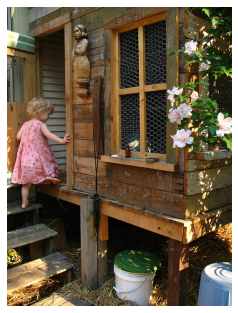

In [12]:

IMG_PATH = "Flickr_data/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

# data cleaning

In [13]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence]
    sentence = " ".join(sentence)
    return sentence

In [14]:
clean_text("A cat is sitting over the house # 64")

'a cat is sitting over the house'

In [15]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [16]:
descriptions["1000268201_693b08cb0e"]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

# writing this data to a text file

In [17]:
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

# creating vocab

In [18]:
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [19]:
print(type(descriptions))

<class 'dict'>


In [20]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8441


In [21]:
"""
#or we can use this method
vocab=set()
for keys in discriptions.keys():
    for sentences in discriptions[keys]:
        sentences=sentences.split()
        vocab.update(sentences)
print(len(vocab),type(vocab))
"""

'\n#or we can use this method\nvocab=set()\nfor keys in discriptions.keys():\n    for sentences in discriptions[keys]:\n        sentences=sentences.split()\n        vocab.update(sentences)\nprint(len(vocab),type(vocab))\n'

In [22]:
vocab=set()
vocab.update(["hi","hello"])
vocab.update(["hello"])
vocab.update(['hey'])
vocab

{'hello', 'hey', 'hi'}

In [23]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 437457


# removing words having very leass frequency

In [24]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8441


In [25]:
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 0
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [26]:

print(len(total_words))

8441


# prepare testing data

In [27]:

train_file_data = readTextFile("Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [28]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [29]:
print(train[:10])
print(len(train))

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154']
6000


In [30]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [31]:
train_descriptions["1000268201_693b08cb0e"]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq']

# image preprocessing

In [32]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_________

In [33]:
model_new = Model(model.input,model.layers[-2].output)

In [34]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [35]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [36]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.04154464, 0.17075905, 0.29276785, ..., 0.05094026, 0.3131964 ,
       0.8600726 ], dtype=float32)

In [37]:
"""#applying encoding_image for all training image
start_t=time()
encoding_train={}
for ix,img_id in enumerate(train):
    img_path=image_path+"/"+img_id+".jpg"
    encoding_train[img_id]=encode_image(img_path)
    
    if ix%100==0:
        print("encoding in process step %d",ix)

end_t=time()
print("time taken is %d",end_t-start_t)"""

'#applying encoding_image for all training image\nstart_t=time()\nencoding_train={}\nfor ix,img_id in enumerate(train):\n    img_path=image_path+"/"+img_id+".jpg"\n    encoding_train[img_id]=encode_image(img_path)\n    \n    if ix%100==0:\n        print("encoding in process step %d",ix)\n\nend_t=time()\nprint("time taken is %d",end_t-start_t)'

In [38]:
#since the conversion takes huge time so we gonna save this on out local disk by using pickle module

In [39]:
"""with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)"""

'with open("encoded_train_features.pkl","wb") as f:\n    pickle.dump(encoding_train,f)'

In [40]:
#loading file again from encoded_train_features.pkl
pickle_off = open ("encoded_train_features.pkl", "rb")
encoding_train= pickle.load(pickle_off)

In [41]:
#using the encoding process for the test images also 

In [42]:
#applying encoding_image for all test image
"""start_t=time()
encoding_test={}
for ix,img_id in enumerate(test):
    img_path=image_path+"/"+img_id+".jpg"
    encoding_test[img_id]=encode_image(img_path)
    
    if ix%100==0:
        print("encoding in process step(test) %d",ix)

end_t=time()
print("time taken is %d",end_t-start_t)"""

'start_t=time()\nencoding_test={}\nfor ix,img_id in enumerate(test):\n    img_path=image_path+"/"+img_id+".jpg"\n    encoding_test[img_id]=encode_image(img_path)\n    \n    if ix%100==0:\n        print("encoding in process step(test) %d",ix)\n\nend_t=time()\nprint("time taken is %d",end_t-start_t)'

In [43]:
"""with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)"""

'with open("encoded_test_features.pkl","wb") as f:\n    pickle.dump(encoding_test,f)'

In [44]:
#loading file again from encoded_test_features.pkl
pickle_off = open ("encoded_test_features.pkl", "rb")
encoding_test= pickle.load(pickle_off)

In [45]:
# Vocab
len(total_words)

8441

In [46]:
#assigning each word a number
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [69]:
with open("word_to_idx.pkl","wb") as w2i:
    pickle.dump(word_to_idx,w2i)

In [70]:
with open("idx_to_word.pkl","wb") as i2w:
    pickle.dump(idx_to_word,i2w)

In [47]:
print(word_to_idx["dog"])
print(idx_to_word[1])
print(len(idx_to_word))

7
a
8441


In [48]:

#adding startseq and endseq in the dict
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 8444


In [49]:
#finding the max length of sentence so that we can take that batch size
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

38


In [50]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
#refer https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

# word embedding using glove vector

In [51]:
f = open("glove.6B.50d.txt",encoding='utf8')

In [52]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [56]:
f.close()

In [57]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [58]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [59]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape


(8444, 50)

# model architecture

In [60]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [61]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [62]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [63]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 38)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 38, 50)       422200      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [64]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [65]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

# model training

In [105]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [106]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('model_weights_image_captioning/model_'+str(i)+'.h5')

In [107]:
train()

Epoch 1/1
2000/2000 [==============================] - 1651s 826ms/step - loss: 4.2080
Epoch 1/1
2000/2000 [==============================] - 989s 495ms/step - loss: 3.4183
Epoch 1/1
2000/2000 [==============================] - 864s 432ms/step - loss: 3.1257
Epoch 1/1
2000/2000 [==============================] - 840s 420ms/step - loss: 2.9355
Epoch 1/1
2000/2000 [==============================] - 843s 421ms/step - loss: 2.7969
Epoch 1/1
2000/2000 [==============================] - 847s 423ms/step - loss: 2.6832
Epoch 1/1
2000/2000 [==============================] - 961s 480ms/step - loss: 2.5987
Epoch 1/1
2000/2000 [==============================] - 947s 473ms/step - loss: 2.5277
Epoch 1/1
2000/2000 [==============================] - 890s 445ms/step - loss: 2.4732
Epoch 1/1
2000/2000 [==============================] - 1413s 706ms/step - loss: 2.4297
Epoch 1/1
2000/2000 [==============================] - 1806s 903ms/step - loss: 2.3937
Epoch 1/1
2000/2000 [==============================

# loading save model

In [66]:
model=load_model("model_weights_image_captioning/model_19.h5")

# model testing(prediction)

In [67]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

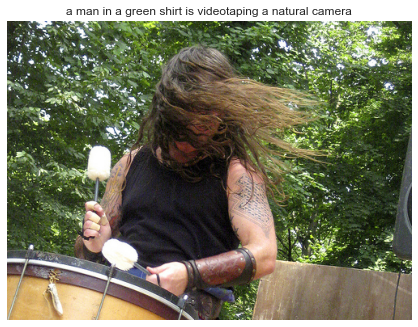

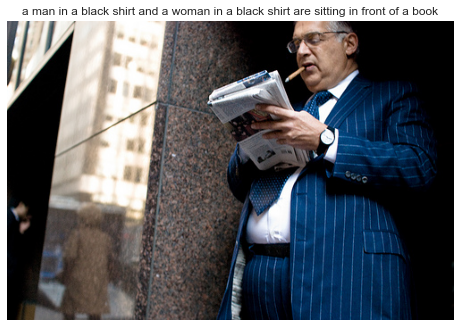

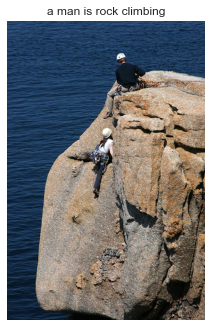

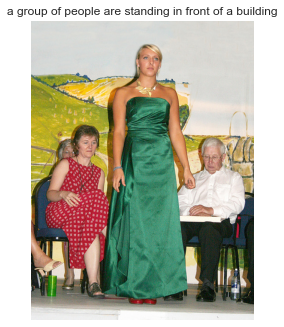

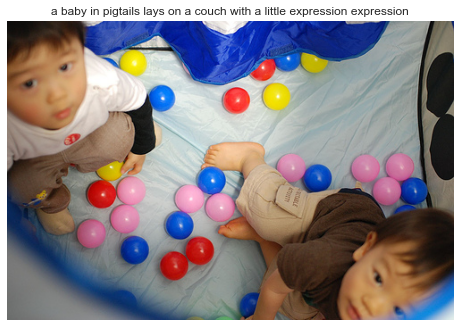

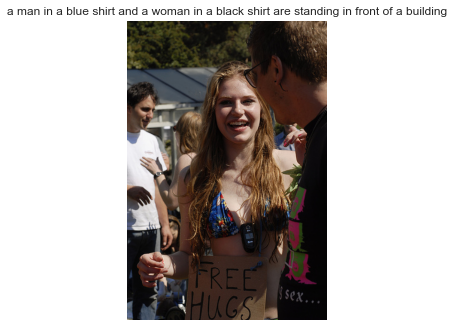

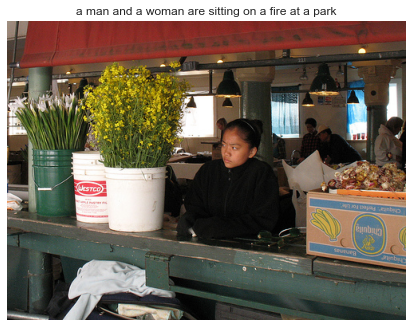

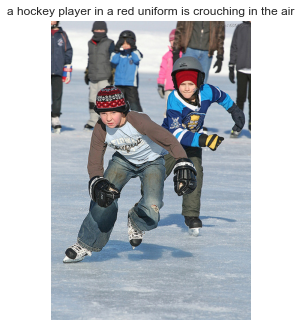

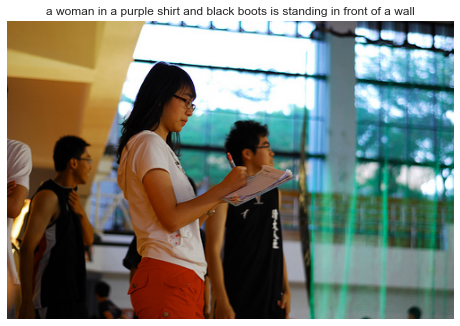

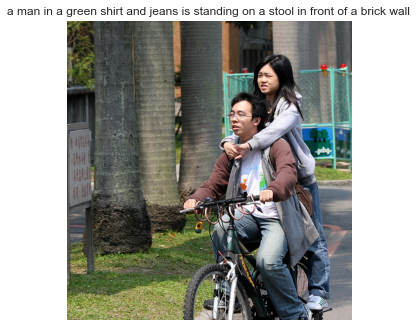

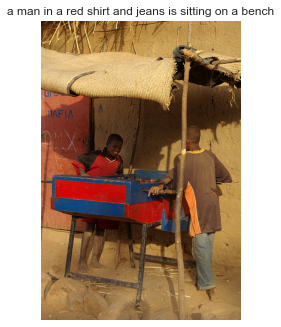

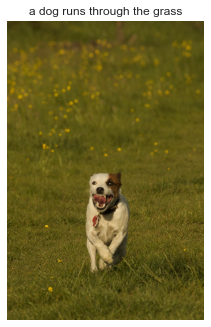

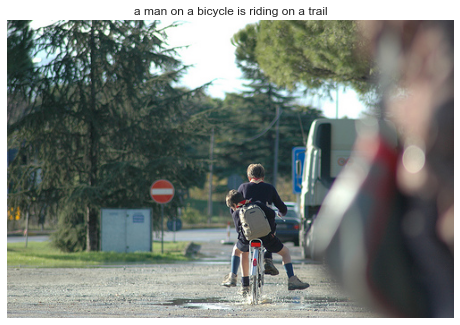

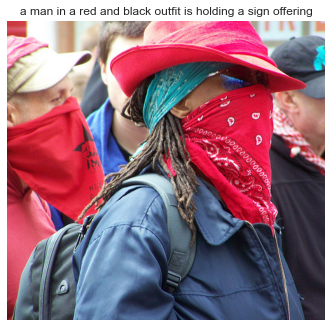

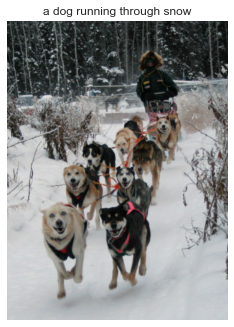

In [68]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Flickr_data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #printing(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()